In [1]:
!pip install openl3
!pip install tqdm
!pip install av

  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.4/323.4 kB 29.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openl3: filename=openl3-0.4.2-py2.py3-none-any.whl size=249327030 sha256=a0b460bd8a37c24c6cc3c8d2b2902e71962c6e09fbfcf005ee2797443732e19b
  Stored in directory: /root/.cache/pip/wheels/35/e9/4c/b1e39385b21f2b4d70c01b8793ecc921d69f167cc772868abe
  Created wheel for kapre: filename=kapre-0.3.7-py3-none-any.whl size=29642 sha256=f30bd7e6976b5ac80bf46886cf7110095669f51235b8d732df283b2e21bccb6a
  Stored in directory: /root/.cache/pip/wheels/d2/17/ce/09b7d799a7c8b463b0a1657941331e0f10112864ff78d28f87
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320705 sha256=a54d324ddbee8c5d25f79694d72992d0c8d412837c5ca13b83b57af10a76c52d
  Stored in directory: /root/

In [2]:
import torch
import torch.nn as nn
import torchvision.models.video as video_models
import openl3
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, ConcatDataset
import torch.optim as optim
from torchvision.io import read_video
import torchaudio
from pathlib import Path
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Tweaks to fix GPU bugs faced
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class ProjectionHead(nn.Module):
    def __init__(self, in_dim, proj_dim=128, hidden_dim=512, dropout=0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, proj_dim)
        )

    def forward(self, x):
        x = self.net(x)
        x = F.normalize(x, dim=1)  # L2-normalize for cosine similarity
        return x


In [6]:
class VideoEncoder(nn.Module):
    def __init__(self, proj_dim=128, freeze_weights=True):
        super().__init__()
        base_model = video_models.r3d_18(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
        self.proj_head = ProjectionHead(512, proj_dim)

        if freeze_weights:
          for param in self.feature_extractor.parameters():
              param.requires_grad = False

    def forward(self, x):  # (B, C, T, H, W)
        x = self.feature_extractor(x)  # (B, 512, 1, 1, 1)
        x = x.view(x.size(0), -1)
        return self.proj_head(x)

In [7]:
class OpenL3Encoder(nn.Module):
    def __init__(self, proj_dim=128, input_repr="mel256", content_type="music", embedding_size=512):
        super().__init__()
        self.sr = 48000
        self.model = openl3.models.load_audio_embedding_model(
            input_repr=input_repr,
            content_type=content_type,
            embedding_size=embedding_size
        )
        self.embedding_size = embedding_size
        self.proj_head = ProjectionHead(embedding_size, proj_dim)

    def forward(self, x):
        embeddings = []

        # --- Determine input type and batch size ---
        is_list_input = isinstance(x, list)
        if is_list_input:
            batch_size = len(x)
            if batch_size == 0: # Handle empty list case
                 device = self.proj_head.net[0].weight.device
                 empty_proj_input = torch.empty(0, self.embedding_size).to(device)
                 return self.proj_head(empty_proj_input)
            # Get device from first tensor in list
            device = x[0].device
        elif isinstance(x, torch.Tensor):
            batch_size = x.size(0)
            if batch_size == 0: # Handle empty tensor case
                 device = self.proj_head.net[0].weight.device
                 empty_proj_input = torch.empty(0, self.embedding_size).to(device)
                 return self.proj_head(empty_proj_input)
            device = x.device # Get device from the tensor itself
        else:
            raise TypeError(f"OpenL3Encoder expects input as list or tensor, got {type(x)}")


        # --- Process each audio sample ---
        for i in range(batch_size):
            if is_list_input:
                audio_tensor = x[i] # Get the i-th tensor from the list
            else:
                audio_tensor = x[i, :] # Get the i-th slice from the batch tensor

            # Ensure tensor is 1D numpy array for openl3
            # Squeeze potentially removes channel dim if present (e.g., [1, L] -> [L])
            audio_np = audio_tensor.squeeze().detach().cpu().numpy()

            # Check dimensions and emptiness *before* calling openl3
            if audio_np.ndim != 1:
                print(f"Warning: Audio sample {i} has unexpected shape {audio_np.shape} before openl3. Skipping.")
                # Append a placeholder embedding matching the expected device and size
                emb_mean = torch.zeros(self.embedding_size, device=device).float()
            elif audio_np.size == 0:
                 print(f"Warning: Audio sample {i} is empty before openl3. Skipping.")
                 emb_mean = torch.zeros(self.embedding_size, device=device).float()
            else:
                try:
                    # Process with OpenL3 using the correct model attribute name
                    emb, _ = openl3.get_audio_embedding(audio_np, self.sr, model=self.model, center=True, verbose=False)
                    # Aggregate embeddings and move to the correct device
                    emb_mean = torch.tensor(emb.mean(axis=0), device=device).float()
                    if emb_mean.shape[0] != self.embedding_size:
                        print(f"Warning: OpenL3 output embedding size mismatch for sample {i}. Got {emb_mean.shape[0]}, expected {self.embedding_size}. Using zeros.")
                        emb_mean = torch.zeros(self.embedding_size, device=device).float()

                except Exception as e:
                    print(f"Error during openl3.get_audio_embedding for sample {i}: {e}. Using zeros.")
                    import traceback
                    traceback.print_exc() # Print error details
                    emb_mean = torch.zeros(self.embedding_size, device=device).float()


            embeddings.append(emb_mean)

        # Stack embeddings for the batch - should now have 'batch_size' embeddings
        if not embeddings: # Should not happen if batch_size > 0, but as safety check
             print("Warning: Embeddings list is empty before stacking.")
             empty_proj_input = torch.empty(0, self.embedding_size).to(device)
             return self.proj_head(empty_proj_input)

        embeddings_batch = torch.stack(embeddings)  # Shape: (batch_size, embedding_size)

        # Apply the PyTorch projection head
        projected_embeddings = self.proj_head(embeddings_batch)

        return projected_embeddings

In [8]:
class AVContrastiveModel(nn.Module):
    def __init__(self, proj_dim=128, num_classes=10):
        super().__init__()
        self.video_encoder = VideoEncoder(proj_dim)
        self.audio_encoder = OpenL3Encoder(proj_dim)
        self.classifier = nn.Linear(proj_dim * 2, num_classes)  # Classification head

    def forward(self, video, audio):
        z_video = self.video_encoder(video)
        z_audio = self.audio_encoder(audio)
        z = torch.cat([z_video, z_audio], dim=1)  # Concatenate features
        logits = self.classifier(z)  # Get classification logits
        return z_video, z_audio, logits  # Return embeddings and logits

In [9]:
def supervised_contrastive_loss(embeddings, labels, temperature=0.07):
    """
    Compute Supervised Contrastive Loss.

    Args:
        embeddings: Tensor of shape (B, D) - feature embeddings.
        labels: Tensor of shape (B,) - ground-truth labels.
        temperature: float - scaling factor for cosine similarities.

    Returns:
        loss: scalar contrastive loss.
    """
    device = embeddings.device
    B = embeddings.size(0)

    # Normalize embeddings
    embeddings = F.normalize(embeddings, dim=1)

    # Cosine similarity matrix: (B, B)
    sim_matrix = torch.matmul(embeddings, embeddings.T) / temperature

    # Mask self-similarity
    logits_mask = ~torch.eye(B, dtype=torch.bool, device=device)
    sim_matrix = sim_matrix.masked_fill(~logits_mask, -1e9)

    # Create positive mask: (B, B)
    labels = labels.contiguous().view(-1, 1)  # (B, 1)
    positive_mask = (labels == labels.T) & logits_mask  # exclude self-pairs

    # Compute log-softmax over rows
    log_prob = F.log_softmax(sim_matrix, dim=1)

    # For each anchor, average over its positives
    mean_log_prob_pos = (positive_mask * log_prob).sum(dim=1) / positive_mask.sum(dim=1).clamp(min=1)

    # Loss: mean over batch
    loss = -mean_log_prob_pos.mean()

    return loss

In [10]:
class AVContrastiveDataset(Dataset):
    def __init__(
        self,
        root_dir="/content/drive/MyDrive/clipped_data",      # Original data structure (for finding samples)
        aug_root="/content/drive/MyDrive/augmented_data",    # Root for augmented files
        video_aug_dirs=["crop_color", "crop_sobel"], # Subdirs under aug_root
        audio_aug_dirs=["bg_noise", "drc"],          # Subdirs under aug_root
        num_frames=16,
        video_size=(112, 112),
        audio_sr=48000,
        samples_list=None
    ):
        self.root = Path(root_dir)
        self.aug_root = Path(aug_root)
        self.video_aug_dirs = video_aug_dirs
        self.audio_aug_dirs = audio_aug_dirs
        self.num_frames = num_frames
        self.video_size = video_size
        self.audio_sr = audio_sr
        self.samples = []

        if samples_list is not None:
            print(f"Initializing dataset with provided list of {len(samples_list)} samples.")
            self.samples = samples_list
            # Need to determine classes and class_to_idx from the provided list
            # Assuming samples_list contains tuples like (class_name, base_name)
            if self.samples:
                 self.classes = sorted(list(set(s[0] for s in self.samples)))
            else:
                 self.classes = []
            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        else:

            # Collect all .mp4 files under class folders in the ORIGINAL directory
            self.samples = []
            # Ensure root directory exists
            if not self.root.is_dir():
                raise FileNotFoundError(f"Root directory '{self.root}' not found.")

            self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()]) #[:5]
            if not self.classes:
                print(f"Warning: No class subdirectories found in '{self.root}'. Dataset will be empty.")

            self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

            for cls in self.classes:
                class_path = self.root / cls
                if not class_path.is_dir():
                    print(f"Warning: Expected directory, but found file: {class_path}")
                    continue
                found_files = False
                for video_path in class_path.glob("*.mp4"):
                    base_name = video_path.stem
                    self.samples.append((cls, base_name)) # Store class and base filename
                    found_files = True
                if not found_files:
                    print(f"Warning: No .mp4 files found in class directory: {class_path}")

        if not self.samples:
             print(f"Warning: No samples collected. Check '{self.root}' structure and content.")


    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        cls, base = self.samples[idx]
        label = self.class_to_idx[cls]

        video_aug = random.choice(self.video_aug_dirs)
        audio_aug = random.choice(self.audio_aug_dirs)

        video_path = self.aug_root / video_aug / cls / f"{base}.mp4"
        audio_path = self.aug_root / audio_aug / cls / f"{base}.wav"

        try:
            video, _, _ = read_video(str(video_path), pts_unit="sec")
            if video.nelement() == 0:
                raise RuntimeError(f"Empty video at {video_path}")

            video = video.permute(0, 3, 1, 2).float() / 255.0  # T x C x H x W
            T_total = video.size(0)
            if T_total <= 0:
                raise RuntimeError(f"Invalid T_total={T_total} at {video_path}")

            if T_total > self.num_frames:
                start = random.randint(0, T_total - self.num_frames)
                video = video[start:start + self.num_frames]
            else:
                repeat = (self.num_frames + T_total - 1) // T_total
                video = video.repeat((repeat, 1, 1, 1))[:self.num_frames]

            video = torch.nn.functional.interpolate(video, size=self.video_size, mode='bilinear', align_corners=False)
            video = video.permute(1, 0, 2, 3)  # → C x T x H x W

            waveform, sr = torchaudio.load(str(audio_path))
            if waveform.shape[0] > 1:
                waveform = waveform.mean(dim=0, keepdim=True)
            if sr != self.audio_sr:
                resampler = torchaudio.transforms.Resample(sr, self.audio_sr)
                waveform = resampler(waveform)

        except Exception as e:
            print(f"ERROR with sample idx {idx} ({video_path}, {audio_path}): {e}")
            raise

        return video, waveform.squeeze(0), label  # optionally: , (cls, base)

### Evaluation Code that uses audio-visual retrieval

Idea is that we take some random audio and use the model to see which video it correponds to. Award points if the video is the same instrument type the audio corresponds to.

In [11]:
@torch.no_grad()
def evaluate_classification(model, val_dataloader, device):
    model.eval()
    correct = 0
    total = 0

    for video, audio, labels in val_dataloader:
        video = video.to(device)
        audio = [a.to(device) for a in audio]
        labels = labels.to(device)

        _, _, logits = model(video, audio)
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Validation Accuracy: {accuracy:.4f}")
    model.train()
    return accuracy

### Training Loop

Train the AVContrastiveModel

In [12]:
# --- Data Loading and Splitting ---
print("Loading and splitting data...")
# 1. Load all samples first (modify dataset __init__ or do it here)
full_dataset_reader = AVContrastiveDataset() # Needs access to self.samples
all_samples = full_dataset_reader.samples
all_classes = full_dataset_reader.classes
num_classes = len(all_classes)

train_samples, val_samples = train_test_split(all_samples, test_size=0.3, random_state=42) # Use random_state for reproducibility
print(f"Total samples: {len(all_samples)}, Train: {len(train_samples)}, Val: {len(val_samples)}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and optimizer
model = AVContrastiveModel(proj_dim=128, num_classes=num_classes).to(device) # Pass num_classes
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Training and validating with augmented data
train_dataset = AVContrastiveDataset(samples_list=train_samples)
val_dataset = AVContrastiveDataset(samples_list=val_samples)

# Training without augmented data, validating with augmented data
"""
train_dataset = AVContrastiveDataset(samples_list=train_samples, use_augmentation=False)
aug_val_dataset = AVContrastiveDataset(samples_list=val_samples, use_augmentation=True)
no_aug_val_dataset = AVContrastiveDataset(samples_list=val_samples, use_augmentation=False)
combined_val_dataset = ConcatDataset([aug_val_dataset, no_aug_val_dataset]) # Pass val samples
"""

# Training on both augmented/unaugmented data, validation with nonaugmented data
"""
aug_train_dataset = AVContrastiveDataset(samples_list=train_samples, use_augmentation=True)
no_aug_train_dataset = AVContrastiveDataset(samples_list=train_samples, use_augmentation=False)
combined_train_dataset = ConcatDataset([aug_train_dataset, no_aug_train_dataset])
val_dataset = AVContrastiveDataset(samples_list=val_samples, use_augmentation=False)
"""

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=12) # Larger batch size for eval usually okay

Loading and splitting data...
Total samples: 1030, Train: 721, Val: 309


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:00<00:00, 231MB/s]


Initializing dataset with provided list of 721 samples.
Initializing dataset with provided list of 309 samples.


In [ ]:
# Training loop
num_epochs = 40
epoch_losses = []
epoch_v2a_r1 = [] # for storing contrastive loss
epoch_a2v_r1 = [] # for storing classification loss
epoch_classification_accuracy = []

for epoch in range(num_epochs):
    model.train()
    total_contrastive_loss = 0 # for storing contrastive loss
    processed_batches = 0

    for i, (video, audio, labels) in enumerate(train_dataloader):
        # video: (B, C, T, H, W), audio: (B, L)
        video = video.to(device)
        audio = [a.to(device) for a in audio]  # individual waveforms (already variable length)
        labels = labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        z_video, z_audio, logits = model(video, audio)  # OpenL3 handles audio per-sample
        # Concatenate embeddings and duplicate labels
        embeddings = torch.cat([z_video, z_audio], dim=0)        # shape (2B, D)
        extended_labels = torch.cat([labels, labels], dim=0)     # shape (2B,)

        # Compute supervised contrastive loss
        loss = supervised_contrastive_loss(embeddings, extended_labels, temperature=0.07)

        loss.backward()
        optimizer.step()

        total_contrastive_loss += loss.item()

        # Calculate accuracy (for evaluation only)
        _, predicted = torch.max(logits, 1)
        accuracy = (predicted == labels).sum().item() / labels.size(0)

        processed_batches += 1

    # --- End of Epoch Evaluation ---
    if processed_batches > 0:
        avg_contrastive_loss = total_contrastive_loss / processed_batches
        epoch_losses.append(avg_contrastive_loss) # store contrastive loss
        epoch_v2a_r1.append(avg_contrastive_loss) # store contrastive loss
        print(f"--- [Epoch {epoch+1}/{num_epochs}] Avg Training Contrastive Loss: {avg_contrastive_loss:.4f}333  ---")
    else:
        epoch_losses.append(float('nan'))
        print(f"--- [Epoch {epoch+1}/{num_epochs}] No batches processed in training ---")

print("Training finished.")

# --- Plotting ---
print("Generating plots...")
fig, ax = plt.subplots(figsize=(20, 5))

# Plot Contrastive Loss
plot_epochs_loss = [i + 1 for i, loss in enumerate(epoch_losses) if not torch.isnan(torch.tensor(loss))]
plot_losses = [loss for loss in epoch_losses if not torch.isnan(torch.tensor(loss))]
if plot_epochs_loss:
    ax.plot(plot_epochs_loss, plot_losses, marker='o', linestyle='-')
    ax.set_title('Average Contrastive Training Loss per Epoch')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Average Contrastive Loss')
    ax.set_xticks(plot_epochs_loss)
    ax.grid(True)


plt.tight_layout()
plt.show()
print("Plots displayed.")

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '/content/drive/MyDrive/projection_heads.pth')
print("Model weights saved successfully!")

Model weights saved successfully!


In [ ]:
state_dict = torch.load('/content/drive/MyDrive/projection_heads.pth', map_location=device)
model.load_state_dict(state_dict)

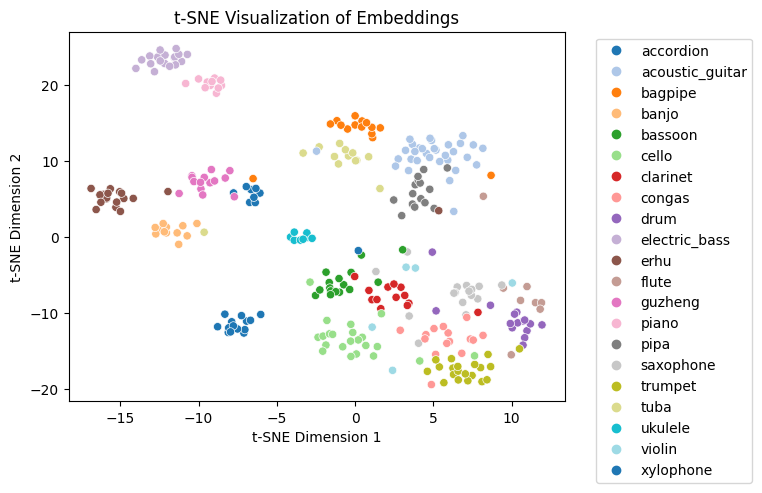

In [15]:
from sklearn.manifold import TSNE

# Function to extract embeddings
def get_embeddings(model, dataloader, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for video, audio, labels in dataloader:
            video = video.to(device)
            audio = [a.to(device) for a in audio]

            z_video, z_audio, _ = model(video, audio)

            embeddings = torch.cat([z_video, z_audio], dim=1)

            all_embeddings.append(embeddings.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_embeddings), torch.cat(all_labels)

# Get embeddings from validation set
embeddings, labels = get_embeddings(model, val_dataloader, device)

# Get class names from class_to_idx (from previous answer)
index_to_class = {v: k for k, v in val_dataloader.dataset.class_to_idx.items()}
class_names = [index_to_class[label.item()] for label in labels]

# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings.numpy())

# Create a DataFrame for plotting with Seaborn
df = pd.DataFrame({'t-SNE Dimension 1': embeddings_2d[:, 0],
                   't-SNE Dimension 2': embeddings_2d[:, 1],
                   'Class': class_names})

# Plot with class names
sns.scatterplot(data=df, x='t-SNE Dimension 1', y='t-SNE Dimension 2', hue='Class',
                palette=sns.color_palette("tab20", len(df['Class'].unique())), legend=False)  # Remove default legend

handles = []
unique_classes = sorted(list(set(class_names)))  # Get unique class names
for class_name in unique_classes:
    # Find an example point for each class to get its color/style
    example_idx = class_names.index(class_name)
    handle = plt.Line2D([0], [0], marker='o', color=sns.color_palette("tab20", len(unique_classes))[unique_classes.index(class_name)], linestyle='', label=class_name)
    handles.append(handle)  # Add this handle to the list
plt.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left')  # Custom legend placement

plt.title('t-SNE Visualization of Embeddings')
plt.show()

Fine-tuning Epoch [1/20] - Loss: 3.0118, Accuracy: 0.1567
Validation Accuracy: 0.2880
Fine-tuning Epoch [2/20] - Loss: 2.9134, Accuracy: 0.5187
Validation Accuracy: 0.5793
Fine-tuning Epoch [3/20] - Loss: 2.8126, Accuracy: 0.7642
Validation Accuracy: 0.6278
Fine-tuning Epoch [4/20] - Loss: 2.7180, Accuracy: 0.8128
Validation Accuracy: 0.6893
Fine-tuning Epoch [5/20] - Loss: 2.6278, Accuracy: 0.8502
Validation Accuracy: 0.7184
Fine-tuning Epoch [6/20] - Loss: 2.5362, Accuracy: 0.8669
Validation Accuracy: 0.7411
Fine-tuning Epoch [7/20] - Loss: 2.4407, Accuracy: 0.9015
Validation Accuracy: 0.7670
Fine-tuning Epoch [8/20] - Loss: 2.3625, Accuracy: 0.8835
Validation Accuracy: 0.7605
Fine-tuning Epoch [9/20] - Loss: 2.2858, Accuracy: 0.9001
Validation Accuracy: 0.7476
Fine-tuning Epoch [10/20] - Loss: 2.2090, Accuracy: 0.9112
Validation Accuracy: 0.7638
Fine-tuning Epoch [11/20] - Loss: 2.1353, Accuracy: 0.9098
Validation Accuracy: 0.8188
Fine-tuning Epoch [12/20] - Loss: 2.0540, Accuracy: 

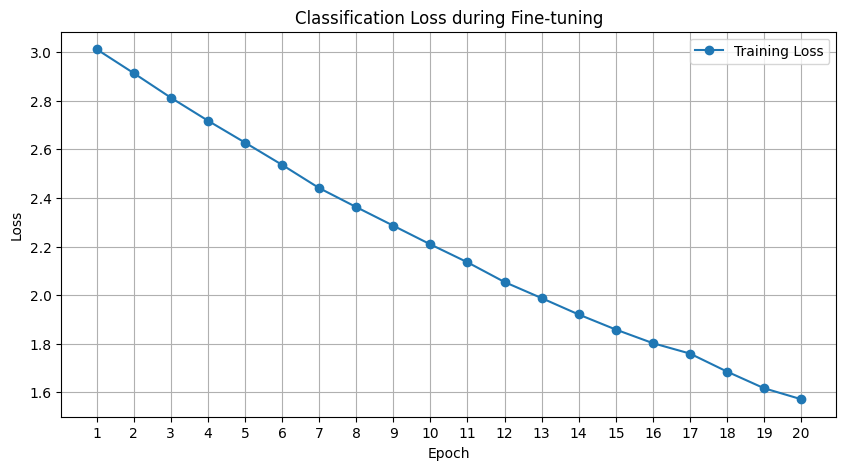

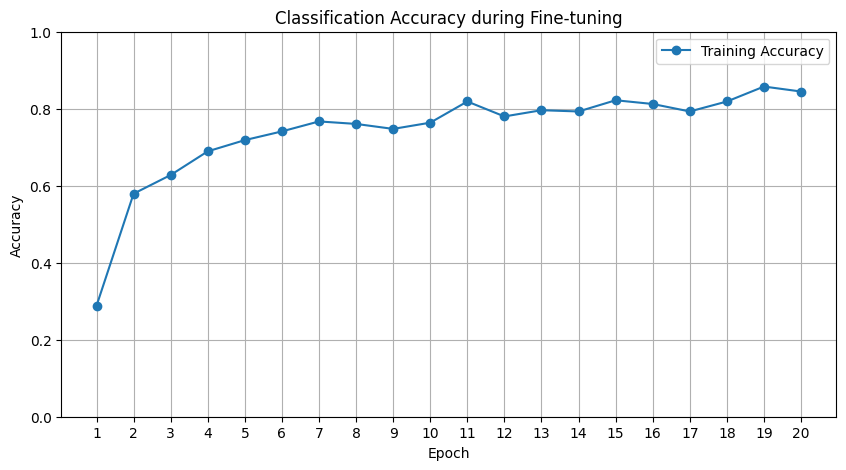

In [ ]:
# --- Fine-tuning the Classification Head ---

# 1. Freeze feature extractors
for param in model.video_encoder.parameters():
    param.requires_grad = False
for param in model.audio_encoder.parameters():
    param.requires_grad = False

# 2. Adjust optimizer
optimizer_classifier = optim.AdamW(model.classifier.parameters(), lr=1e-3)

# 3. Fine-tuning loop and plotting
num_fine_tune_epochs = 20
fine_tune_losses = []
fine_tune_accuracies = []

for epoch in range(num_fine_tune_epochs):
    model.train()
    epoch_loss = 0.0
    epoch_correct = 0
    epoch_total = 0

    for video, audio, labels in train_dataloader:
        video = video.to(device)
        audio = [a.to(device) for a in audio]
        labels = labels.to(device)

        optimizer_classifier.zero_grad()
        _, _, logits = model(video, audio)
        classification_loss = F.cross_entropy(logits, labels)

        classification_loss.backward()
        optimizer_classifier.step()

        epoch_loss += classification_loss.item()
        _, predicted = torch.max(logits, 1)
        epoch_total += labels.size(0)
        epoch_correct += (predicted == labels).sum().item()

    avg_epoch_loss = epoch_loss / len(train_dataloader)
    avg_epoch_accuracy = epoch_correct / epoch_total

    fine_tune_losses.append(avg_epoch_loss)
    fine_tune_accuracies.append(avg_epoch_accuracy)

    print(f"Fine-tuning Epoch [{epoch+1}/{num_fine_tune_epochs}] - Loss: {avg_epoch_loss:.4f}, Accuracy: {avg_epoch_accuracy:.4f}")

    # Evaluate on validation set after each fine-tuning epoch
    val_accuracy = evaluate_classification(model, val_dataloader, device)
    fine_tune_accuracies.append(val_accuracy)

print("Fine-tuning finished.")

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, '/content/drive/MyDrive/contrastive_loss_40_epochs.pth')
print("Model weights saved successfully!")

Model weights saved successfully!


In [13]:
state_dict = torch.load('/content/drive/MyDrive/contrastive_loss_40_epochs.pth', map_location=device)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
@torch.no_grad()
def per_class_accuracy(model, dataloader, device, num_classes):
    """
    Calculates the per-class accuracy of the model.

    Args:
        model: The trained model.
        dataloader: The DataLoader for the dataset.
        device: The device to run the computation on (e.g., 'cuda' or 'cpu').
        num_classes: The total number of classes in the dataset.

    Returns:
        A list containing the accuracy for each class.
    """

    model.eval()
    class_correct = [0] * num_classes
    class_total = [0] * num_classes

    for video, audio, labels in dataloader:
        video = video.to(device)
        audio = [a.to(device) for a in audio]
        labels = labels.to(device)

        _, _, logits = model(video, audio)
        _, predicted = torch.max(logits, 1)

        # Count correct predictions for each class
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if predicted[i] == labels[i]:
                class_correct[label] += 1

    # Calculate accuracy for each class
    class_accuracies = [
        class_correct[i] / class_total[i] if class_total[i] else 0
        for i in range(num_classes)
    ]

    return class_accuracies

index_to_class = {v: k for k, v in val_dataloader.dataset.class_to_idx.items()}

# --- Usage ---
class_accuracies = per_class_accuracy(model, val_dataloader, device, num_classes)

# Print per-class accuracies
for i, accuracy in enumerate(class_accuracies):
    class_name = index_to_class[i]  # Get class name from index
    print(f"Class {class_name}: Accuracy = {accuracy:.4f}")

# Calculate average per-class accuracy
avg_per_class_accuracy = sum(class_accuracies) / len(class_accuracies)
print(f"Average Per-Class Accuracy: {avg_per_class_accuracy:.4f}")

Class accordion: Accuracy = 1.0000
Class acoustic_guitar: Accuracy = 0.9688
Class bagpipe: Accuracy = 1.0000
Class banjo: Accuracy = 0.6923
Class bassoon: Accuracy = 0.9231
Class cello: Accuracy = 0.7727
Class clarinet: Accuracy = 0.5000
Class congas: Accuracy = 0.9091
Class drum: Accuracy = 1.0000
Class electric_bass: Accuracy = 0.9333
Class erhu: Accuracy = 0.6000
Class flute: Accuracy = 0.7333
Class guzheng: Accuracy = 0.8571
Class piano: Accuracy = 1.0000
Class pipa: Accuracy = 0.8889
Class saxophone: Accuracy = 0.0000
Class trumpet: Accuracy = 0.3750
Class tuba: Accuracy = 0.7500
Class ukulele: Accuracy = 0.8667
Class violin: Accuracy = 1.0000
Class xylophone: Accuracy = 0.9167
Average Per-Class Accuracy: 0.7946
